In [1]:
from multiprocessing import Pool
import multiprocessing as mp
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from astropy.wcs import WCS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import spearmanr

from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm
import datetime

import emcee
import corner

import h5py
import multiprocessing as mp

In [2]:
import globalvars
dust_data = globalvars.DustData()

In [3]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

/tmp/ipykernel_3155259/2315330892.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  edenhofer = np.array(f['data'])


In [4]:
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res, get_medres
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
from sightline import Sightline
import time

In [5]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1010


In [6]:
wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [7]:
ds = 2.5 # x downsampled
rad = 0.23
sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 5
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
        radius_min[i, j] = np.max([radius_min[i, j], 0.23])

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))
radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

selected_inds = []
for i in range(len(l_sample)):
    l_center, b_center = l_sample[i], b_sample[i]
    rad_i = radius_sample[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
    # print(len(selection))
    selected_inds.append(selection)

91
23
28


In [8]:
dibfn = lambda x, mu, sigma, a: 1-a * np.exp(-0.5 * (x - mu)**2 / sigma**2)
def sigma_clip_mask(y, x = wavs, k = 2.5):
    y_over_gauss = None

    try:
        gaussfit = curve_fit(dibfn, x[window], y[window].filled(np.nan), p0 = (15272, 1.2, 0.05), bounds = ([15269, 0.5, 0], [15275, 2, 0.15]), check_finite = False, nan_policy = 'omit')

    except:
        # gaussfit = ((15272, 1.2, 0.05),())
        print('fail')
        return None, None
    #     y_over_gauss = None
    #     gaussfit = ((15272, 1.2, 0.05),())
    #     # fit = dibfn(x, 15272.42, 1.2, 0.05)
    #     # y_over_gauss = y / fit
    #     print('POOR GAUSS FIT IN SIGMA CLIP')
    y_over_gauss = y / dibfn(x, *gaussfit[0])

    med = np.nanmedian(y_over_gauss[window])
    stdev = np.std(y_over_gauss[window], ddof = 1)
    mask = np.abs(y_over_gauss - med) > k * stdev
    mask = mask + np.roll(mask, -1) + np.roll(mask, -1)
    mask = mask.astype(bool)
    return mask, stdev

def sigmaClip(y, yerr,k=2.5):
    clip = True
    clip_iters = 0
    std = np.nanstd(y[window], ddof = 1)
    mask = np.zeros(y.shape).astype(bool)
    clip_success = True

    while clip:
        clip_mask, std_clipped = sigma_clip_mask(np.ma.array(y, mask = mask.copy()), k = k)
        if clip_mask is None:
            clip_success = False
            return mask, clip_success
        clip_mask = clip_mask.filled(False)

        if std - std_clipped  < 1e-4:
            clip = False


        else:
            clip_iters += 1
            std = std_clipped
            mask = mask + clip_mask

    return mask, clip_success

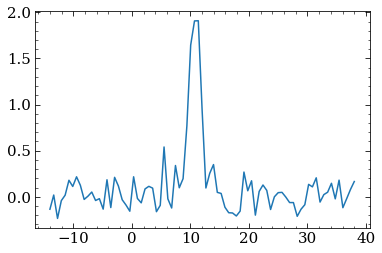

In [9]:
pathCO = '/uufs/astro.utah.edu/common/home/u1371365/Data/Temporary/Catalogs/DHT21_Taurus_interp.fits'
hdulCO = fits.open(pathCO)

headerCO = hdulCO[0].header
dataCO = hdulCO[0].data
wcsCO = WCS(headerCO)

glon = headerCO['CRVAL2'] + headerCO['CDELT2'] * (np.arange(0, headerCO['NAXIS2'])- headerCO['CRPIX2'])
glat = headerCO['CRVAL3'] + headerCO['CDELT3'] * (np.arange(0, headerCO['NAXIS3'])- headerCO['CRPIX3'])
rvel = headerCO['CRVAL1'] + headerCO['CDELT1'] * (np.arange(0, headerCO['NAXIS1'])- headerCO['CRPIX1'])

l, b, v = np.meshgrid(glon, glat, rvel)
coord = SkyCoord(l * u.deg, b  * u.deg, radial_velocity = v * u.km/u.s, pm_l_cosb = 0 * u.deg/u.s,
                  pm_b = 0 * u.deg /u.s, distance = 500 * u.pc, frame = 'galacticlsr')

coord_icrs = coord.transform_to('icrs')

def get_CO_profile(l, b):
    coord_sel = SkyCoord(l = l * u.deg, b = b * u.deg, frame = 'galactic')
    pix_ind_l, pix_ind_b = wcsCO.world_to_pixel(0 * u.km/u.s, coord_sel)[1:]
    CO_profile = dataCO.T[:, int(pix_ind_l), int(pix_ind_b)]
    rvel = coord_icrs.T.radial_velocity[:, int(pix_ind_l), int(pix_ind_b)]
    return CO_profile, rvel
profile, rvel = get_CO_profile(165, -7)

plt.plot(rvel, profile)

In [10]:
def generateClippedResidual(aspcap, medres, apstar, rv, k = 2.5):
    spectrum = aspcap[1].data
    model = aspcap[3].data
    err = aspcap[2].data
    bitmask = apstar[3].data[0, :]

    if medres[1].data is None:
        medres_model = np.ones(spectrum.shape)
        medres_err =np.zeros(spectrum.shape)
    else:
        medres_model = np.array(medres[1].data)
        medres_err = np.array(medres[3].data)



    mask_digits = [0, 1, 2, 9, 12, 13] # 0 BADPIX, 1 CRPIX, 2 SATPIX, 9 PERSIST_HIGH, 12 SIG_SKYLINE, 13 SIG_TELLURIC
    mask = np.zeros(bitmask.shape)
    for digit in mask_digits:
        mask = mask + np.bitwise_and(bitmask.astype(int), 2**digit) 

    mask = mask.astype(bool)
    res_corr = spectrum / model / medres_model
    # print('res corr shape', res_corr.shape)
    uncertainty_corr = np.sqrt(err**2 + medres_err**2)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)

    # mask_sigmaclip = np.zeros(len(wavs))


    maskSigClip, clip_success = sigmaClip(res_corr, uncertainty_corr, k = k)

    mask = mask + maskSigClip
    mask = mask.astype(bool)

    res_corr_ma = np.ma.array(res_corr, mask = mask)
    res_corr_filled = res_corr_ma.filled(np.nan)

    res_corr_resamp = resample_interp(res_corr_filled, rv)
    uncertainty_corr_resamp = resample_interp(uncertainty_corr, rv)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)


    res_corr_resamp = np.ma.array(res_corr_resamp, mask = manual_masks)
    res_corr_resamp = res_corr_resamp.filled(np.nan)


    return res_corr_resamp, uncertainty_corr_resamp#, clip_success

In [11]:
from spacefns_v2 import dAV_dd_array
from residual_process import reprocess
from filehandling import getASPCAP, getapStar

class ForegroundModifiedSightline(Sightline):
    def __init__(self, stars, coords = None, dAVdd = None, dfore = 400, **kwargs):
        # self.all_stars = stars
        self.stars = stars[stars['DIST'] > dfore]
        dist = self.stars['DIST']

        self.make_fgbins()
        self.bin_inds = np.digitize(dist, self.bins)

        if coords is not None:
            self.l, self.b = coords
        else:
            self.l, self.b = (np.nanmean(self.stars['GLON']), np.nanmean(self.stars['GLAT']))
        
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs(**kwargs)

        self.ndim = len(self.voxel_dAVdd)
        self.nsig = len(self.stars)

        self.test_init_signals = self.model_signals_fg(self.rvelo, self.dAVdd)
    
    def get_DIBs(self, MADGICS = False, alternative_data_processing = None, **kwargs):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_all = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_mask =np.zeros((len(self.stars), len(self.bins)-1)).astype(bool)

        if alternative_data_processing is not None:
            # needs to take aspcap, medres, apstar, rv as arguments
            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                aspcap = fits.open(getASPCAP(star))
                apstar = fits.open(getapStar(aspcap))
                medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))
                sig, err = alternative_data_processing(aspcap, medres, apstar, star_rv)
                signals[i, :], signal_errs[i, :] = sig[window], err[window]

               
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)
        
        else:
            if MADGICS:
                signals_aspcap = np.zeros((len(self.stars), len(wavs_window)))
                signal_errs_aspcap = np.zeros((len(self.stars), len(wavs_window)))

            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                res_hdul = fits.open(get_ca_res(star['FILE']))
                signals[i, :] = res_hdul[1].data[window]
                signal_errs[i, :] = res_hdul[2].data[window]
                reprocess_uncertainty = True
                if reprocess_uncertainty:
                    signal_errs[i, :] = self.reprocess_errs(res_hdul, star['VHELIO_AVG'])[window]
                reprocess_residual = True
                if reprocess_residual:
                    res_repr, err_repr = reprocess(res_hdul, star['VHELIO_AVG'])
                    signals[i, :] = res_repr[window]
                    signal_errs[i, :] = err_repr[window]
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)

                if MADGICS:
                    signals_aspcap[i, :] = np.copy(signals[i, :])
                    signal_errs_aspcap[i, :] = np.copy(signal_errs[i, :])
                    res_hdul_m = fits.open(get_madgics_res(star['FILE']))
                    signals[i, :] = res_hdul_m[1].data[0, 125:][window]



        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        self.voxel_dAVdd = np.nanmedian(dAVdd_all, axis = 0)
        self.voxel_dAVdd_std = np.nanstd(dAVdd_all, axis = 0, ddof = 1)
        self.dAVdd_mask = dAVdd_mask.astype(bool)
        # self.dAVdd_v = dAVdd_v
        if MADGICS:
            self.signals_aspcap = signals_aspcap
            self.signal_errs_aspcap = signal_errs_aspcap

    def make_fgbins(self, binsep = 10, dfore = 400, **kwargs):
        dmin = 0 # start bins at 0pc
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), [0,1], [dmin, dfore]))
        # print('BINS BEFORE THING', bins)
        i = 0
        while i >= 0:
            try:
                next_bin = np.min(bins[bins > bins[i]])
            except:
                print('broke:')
                print(bins[bins > bins[i]])
                print(len(self.stars))

            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins

    def model_signals_fg(self, rvelo, dAVdd=None, binsep = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        if binsep is None:
            binsep = self.bins[1:]-self.bins[:-1]
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins)-1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = differentialAmplitude(dAVdd, binsep)

        def single_signal(amp, bindex):
            amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = differentialAmplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals


In [12]:
sightlines = []
for i in range(len(selected_inds)):
    sightlines.append(ForegroundModifiedSightline(CA_meta[selected_inds[i]], dustdata = dust_data, alternative_data_processing = generateClippedResidual))

/tmp/ipykernel_3155259/3500557254.py:22: RuntimeWarning: invalid value encountered in divide
  res_corr = spectrum / model / medres_model
/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_3155259/3500557254.py:22: RuntimeWarning: divide by zero encountered in divide
  res_corr = spectrum / model / medres_model


In [13]:
sightlines = sightlines[:2]

In [14]:
from MCMCfns import logprob_fg, Logprior_Foreground
def MCMC_fg(sl, steps = 1000, nwalkers = 100, pool = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)

    lp_foreground = Logprior_Foreground(sl.l, sl.b)

    

    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_fg, 
                                    kwargs={'sl': sl, 'lp_fore': lp_foreground}, pool = pool) # OKAY SO I FORGOT TO CHANGE THIS, WAS LOGPROB_2
    # init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init = 10 *  (np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    init[:, ndim:][(init[:, ndim:] <= 0.1)] = 0.11 + 0.05 * np.random.random(np.sum(init[:, ndim:]<= 0.1))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True, );
    
    return sampler, ndim, ndim_amp

In [15]:
sl = sightlines[0]
ndim = len(sl.voxel_dAVdd) 
nstar = len(sl.stars)
ndim_amp = int(ndim + ndim * nstar)
lp_foreground = Logprior_Foreground(sl.l, sl.b)
# lp_foreground.logprior_foreground_v(10, 400)

In [16]:
def logprior_foreground_av(av, distance, foreground_distance = 401 ):
    foreground = distance <= foreground_distance
    prior_val = np.zeros(distance.shape)
    ampfit = [0.2 * 0.01928233, 0.1 * 0.01431857]
    avf = lambda x, mu, sigma :  -(x - mu)**2 / (2 * sigma**2)
    prior_val[foreground] = - 0.5  * np.nansum((av[:, foreground] - ampfit[0])**2 / (ampfit[1]**2))
    return np.nansum(prior_val)

In [17]:
logprior_foreground_av(sl.dAVdd, sl.bins[1:])


-1580241.2313987007

In [18]:
lp_foreground = Logprior_Foreground(sl.l, sl.b)

lp_foreground.logprior_foreground_av(sl.dAVdd, sl.bins[1:])

-62638.915602173525

In [19]:
init = 10 *  (np.random.random((500, ndim_amp)) - 0.5)
init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
init[:, ndim:][(init[:, ndim:] <= 0.1)] = 0.11 + 0.05 * np.random.random(np.sum(init[:, ndim:]<= 0.1))
print(logprob_fg(init[5, :], sl, lp_fore = lp_foreground,))

-930.5334541057481


In [20]:
sl.bins[1:].shape
sl.dAVdd.shape

(4, 5)

In [21]:
print('ndim', sl.ndim)
print('nsig', sl.nsig)
print('signals shape', sl.signals.shape)
print('dA(V)/dd shape', sl.dAVdd.shape)
print('dA(V)/dd shape in logprob fn', sl.dAVdd.flatten().reshape(-1, sl.ndim).shape)

ndim 5
nsig 4
signals shape (4, 95)
dA(V)/dd shape (4, 5)
dA(V)/dd shape in logprob fn (4, 5)


In [22]:
sl.dAVdd

array([[1.42089844, 0.02955627, 0.90771484, 0.        , 0.        ],
       [1.27929688, 0.03353882, 0.8828125 , 0.05215454, 0.00683594],
       [1.296875  , 0.02853394, 0.96777344, 0.05532837, 0.        ],
       [1.08691406, 0.02635193, 0.        , 0.        , 0.        ]])

In [23]:
stp = 1250
# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sTHIsTThisterasdfdsfafsdfsdafampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

if True:
    today = str(datetime.date.today()).split('-')
    datelabel = today[1]+today[2]
    run_label = 'kt_' + datelabel + 'c'
else:
    run_label = 'kt_0513a'

save_individual = False

first_run = True



if first_run:
    if not os.path.exists(os.getcwd() + '/RUNS_FG_SIGCLIP/' + run_label):
        os.makedirs(os.getcwd() +'/RUNS_FG_SIGCLIP/' + run_label)
        inp = input('Please describe this run:')
        with open('RUNS_FG_SIGCLIP/global_log.txt', mode = 'a') as global_log:
            global_log.write('-------------------------------------------- \n')
            global_log.write(run_label)
            global_log.write(inp + '\n \n')
    with Pool(10) as pool:
        for i in range(len(sightlines)):
            # try:
            if True:
                sl_i = sightlines[i]
                smplr, ndm, ndm_amp = MCMC_fg(sl_i, steps = stp, nwalkers = 500, pool = pool)
                # smplr_array.append(smplr)
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                
                sl_i.intake(smplr)
                state = 'success'
            # except Exception as e:
            #     print('Something went wrong')
            #     sl_i = None 
            #     state = 'fail'
            #     with open('RUNS_FG_SIGCLIP/' + run_label + '/FAILS.txt', mode = 'a') as fails:
            #         fails.write(str(e))
                
            with open('RUNS_FG_SIGCLIP/' + run_label + '/LOG.txt', mode = 'a') as log:
                logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
                log.write(logstring)
            
            if save_individual == True:
                with open('RUNS_FG_SIGCLIP/' + run_label + '/sl_{}.pickle'.format(i), mode = 'wb') as f:
                    pickle.dump(sl_i, f)


NDIM: 5 NSTAR: 4 INITSHAPE: (500, 25)


100%|██████████| 1250/1250 [02:11<00:00,  9.50it/s]


NDIM: 6 NSTAR: 5 INITSHAPE: (500, 36)


100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s]


In [24]:
name = run_label

# first_run = False

# if first_run:
#     f = open('RUNS_FG_SIGCLIP/' + run_label + '/sightlines_{}.pickle'.format(name),'wb')
#     pickle.dump(sightlines, f )
#     f.close()
# else:
#     f = open('RUNS_FG_SIGCLIP/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')

#     sightlines = pickle.load(f)
#     f.close()

In [25]:
 # 05.09. Asked Gail about whe ther I wanted to consider adding a higher weight to the likelihood (over the priors), but I don't really know if it's appropriate to do so, and we ultimately decided that it could open things up to being affected by the residuals more. Still...

In [26]:
sightlines[0].bins

array([  0.     , 400.01   , 418.4991 , 525.6287 , 569.89996, 585.31537],
      dtype='>f4')

In [27]:
def polynomial2d( x1, x2, theta = None, uncert = None):  
        if theta is None:
            theta = np.array([5.03964666, -1.04129592, -0.72842925, -0.20292219,  0.0206567,  -0.14442016])
        if uncert is None:
            uncert = 2.404363059339516
        if np.array(x1).ndim != 1:
            x1 = np.array([x1])
            x2 = np.array([x2])
        x1 = x1 - 160 # FOR CA CLOUD SPECIFICIALLY
        x2 = x2 + 8 # DITTO
        X = np.array([[np.ones(np.array(x1).shape), x1, x2, x1 * x2, x1**2, x2**2]]).T
        matrix = X * theta[:, np.newaxis]
        print(matrix.shape)
        return np.nansum(matrix, axis = 1).flatten()

def box(x, min = -8.5, max = 17.5):
     y = np.ones(len(x))
     y[x < min] = 0
     y[x > max] = 0
     return y

def prior_for_plot(l, b, x ):
    gaussn = lambda x, mu, sig : 1/(np.sqrt(2 * np.pi) * sig) * np.exp(-(x - mu)**2 / (2* sig**2))     
    # x = np.linspace(-20, 20, 100)
    sig =  2.404363059339516
    mu = polynomial2d(l, b)
    print(mu)
    return gaussn(x, mu, sig) #* box(x)

priorx = np.linspace(-20, 20, 100)

(100000, 5)
(1, 6, 1)
[6.14218021]


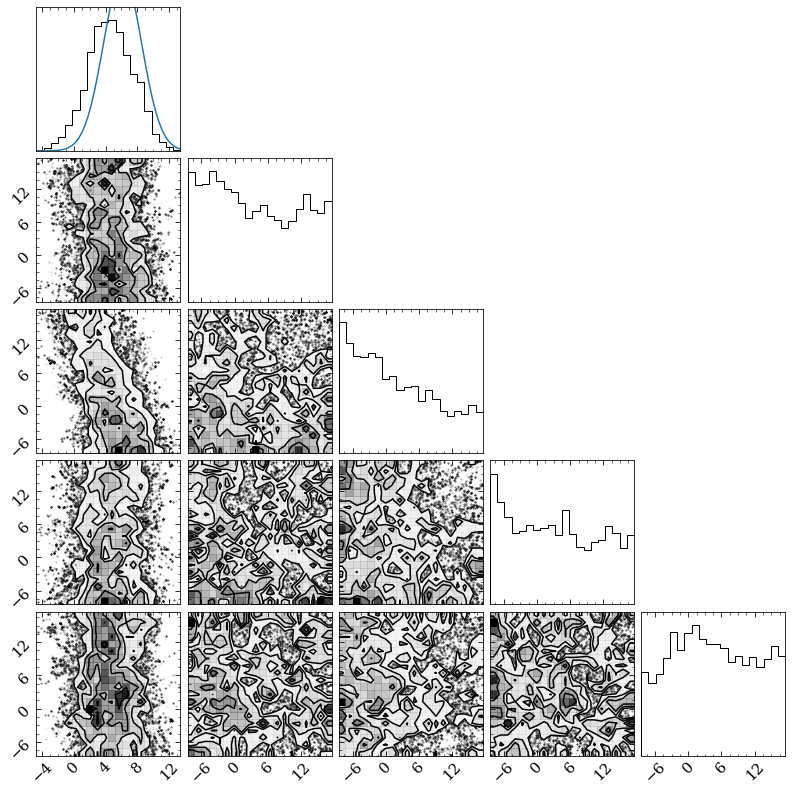

(100000, 6)
(1, 6, 1)
[5.94630487]


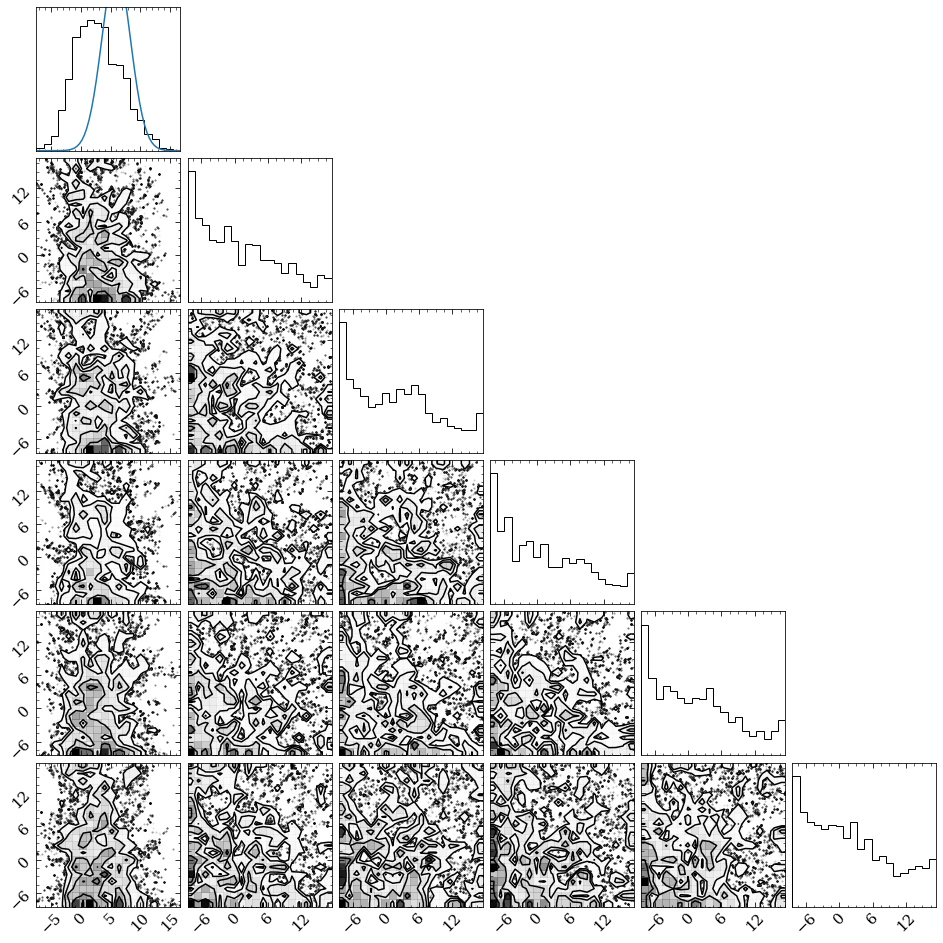

In [28]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = -100):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    return fig
    plt.show()

if True:
    for i in range(0, len(sightlines)):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        fig = make_corner_vonly(sl_i.sampler, ndim, labels = None, minval =-200)
        axes = np.array(fig.axes).reshape(ndim, ndim)
        axes[0, 0].plot(priorx, 1e5* prior_for_plot(sl_i.l, sl_i.b, priorx))
        plt.show()

In [29]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    

N 0
ndim 5
nstars 4
medians shape (25,)
[[1.43797747 0.13409668 0.65975688 0.16857344 0.21120051]
 [1.4118938  0.13301962 0.58548376 0.10100086 0.10005198]
 [1.05424978 0.14568592 0.76061722 0.1029978  0.15783982]
 [0.91956268 0.16532121 0.28507122 0.16893312 0.36529184]]
med_velo shape (5,)
med_dAV_dd shape (4, 5)
order_inds [3 0 2 1]
(4, 95) (4, 5, 95) (4, 5)
[[1.43797747 0.13409668 0.65975688 0.16857344 0.21120051]
 [1.4118938  0.13301962 0.58548376 0.10100086 0.10005198]
 [1.05424978 0.14568592 0.76061722 0.1029978  0.15783982]
 [0.91956268 0.16532121 0.28507122 0.16893312 0.36529184]]
[[1.43797747 0.13409668 0.65975688 0.16857344 0.21120051]
 [1.4118938  0.13301962 0.58548376 0.10100086 0.10005198]
 [1.05424978 0.14568592 0.76061722 0.1029978  0.15783982]
 [0.91956268 0.16532121 0.28507122 0.16893312 0.36529184]]
[[1.43797747 0.13409668 0.65975688 0.16857344 0.21120051]
 [1.4118938  0.13301962 0.58548376 0.10100086 0.10005198]
 [1.05424978 0.14568592 0.76061722 0.1029978  0.157839

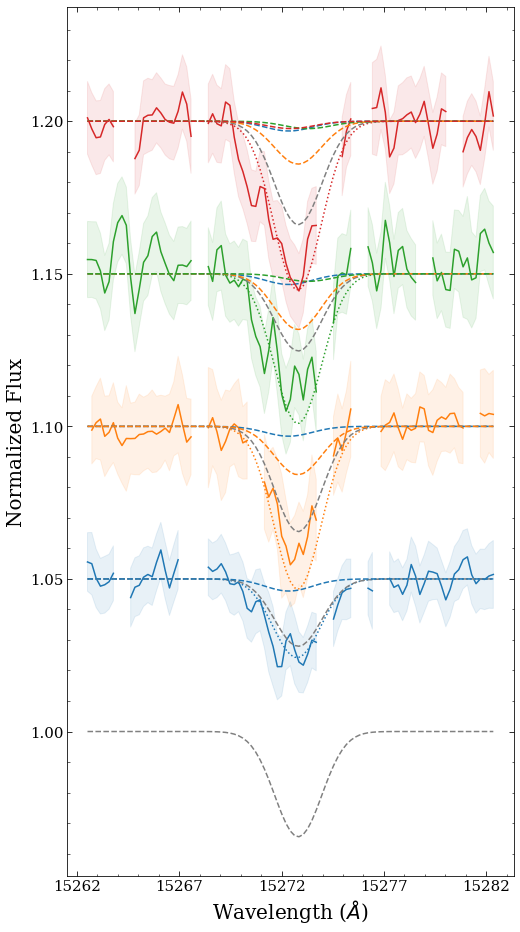

N 1
ndim 6
nstars 5
medians shape (36,)
[[0.76322065 0.34521593 0.45380027 0.22983872 0.10419697 0.17741077]
 [0.51698167 0.51859821 0.1144961  0.18386871 0.16284149 0.12591515]
 [0.67983459 0.47904218 0.3848888  0.21244724 0.12884053 0.22212881]
 [0.66077532 0.49027606 0.24508466 0.17400071 0.22290225 0.17764227]
 [0.60934352 0.17269882 0.28911132 0.20925744 0.10836199 0.15190858]]
med_velo shape (6,)
med_dAV_dd shape (5, 6)
order_inds [1 4 3 0 2]
(5, 95) (5, 6, 95) (5, 6)
[[0.76322065 0.34521593 0.45380027 0.22983872 0.10419697 0.17741077]
 [0.51698167 0.51859821 0.1144961  0.18386871 0.16284149 0.12591515]
 [0.67983459 0.47904218 0.3848888  0.21244724 0.12884053 0.22212881]
 [0.66077532 0.49027606 0.24508466 0.17400071 0.22290225 0.17764227]
 [0.60934352 0.17269882 0.28911132 0.20925744 0.10836199 0.15190858]]
[[0.76322065 0.34521593 0.45380027 0.22983872 0.10419697 0.17741077]
 [0.51698167 0.51859821 0.1144961  0.18386871 0.16284149 0.12591515]
 [0.67983459 0.47904218 0.3848888  0.

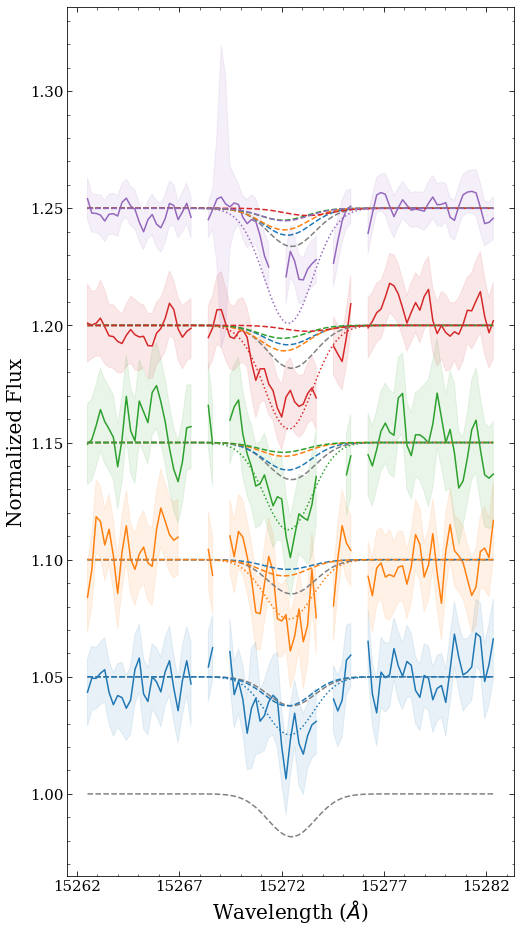

In [30]:
def model_signals_fg(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    voxeldiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    # unsummed_signals = np.zeros((len(sl.bins)-1, len(sl.bins)-1,len(wavs_window)))

    print(voxeldiffDIB.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):

        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 

    fgdiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    

    for i in range(len(sl.stars)): # Iterate over each star in dAVdd array
        print(dAVdd)
        dAVdd_bin = dAVdd[i, :] 

        amp = differentialAmplitude(dAVdd_bin, 1)

        bin_index = np.concatenate([sl.bin_inds]).astype(int)[i] # this only goes to 
        # signals[i, :] = single_signal(bin_index)
        voxeldiffDIB[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)
        fgdiffDIB[i, :], _ = single_signal(amp, 1)


    return voxeldiffDIB, unsummed_signals, fgdiffDIB

def plot_DIBS_fg(sampler, sl, plot_objs = None, bestprob = False):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs

    ndim = len(sl.voxel_dAVdd)
    print('ndim', ndim)
    nstars = len(sl.stars)
    print('nstars', nstars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)
    print('medians shape', medians.shape)

    ## NEW THING
    if bestprob:
        lp = sl.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    print(med_dAV_dd)
    print('med_velo shape', med_velo.shape)
    print('med_dAV_dd shape', med_dAV_dd.shape)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # order_inds = (np.array(np.argsort(sl.stars['DIST'])))
    print('order_inds', order_inds)

    signal_recreated, signal_recreated_unsummed, fg_dibs = model_signals_fg(med_velo, sl, med_dAV_dd) 

    print('signal_recreated.shape', signal_recreated.shape)


    ax.plot(wavs[window], fg_dibs[0, :], linestyle = 'dashed', color ='grey')

    for i in range(len(order_inds)):
        ii = order_inds[i]
        print(ii)
        offset_i = i+1

        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])

        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * offset_i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * offset_i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            if j==0:
                col = 'grey'
            else:
                col = 'C{}'.format(j-1)
            if j > i+1:
                continue
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1  + 0.05 * offset_i, color=col, linestyle = 'dashed', alpha = 1)

    # ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

    # ax.set_yticklabels('')

    return signal_recreated, sl.signals, sl.signal_errs

chi2s = np.zeros(len(sightlines))
sl_lensignals = np.zeros(len(sightlines))

recreated_signals = []

for i in range(len(sightlines)):
    print('N', i)
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sl_lensignals[i] = sl_i.nsig
    sampler_i = sl_i.sampler
    reproducedDIBs, realDIBs, realDIBerrs = plot_DIBS_fg(sampler_i, sl_i, plot_objs = (fig, ax))

    chi2 = np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    chi2s[i] = chi2

    # ymin, ymax = ax.get_ylim()
    # ax.text(lambda0, ymax - .01, str(chi2))

    lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

    name_i = 'dibs_' + str(i)
    # fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/231015_DIBmodels/{}.png'.format(name_i), overwrite = True)

    plt.show()

    ### Added 05.13 ###
    recreated_signals.append(reproducedDIBs)


In [31]:
sl_davdd = np.zeros((len(l_sample.flatten()), dust_data.dustmap.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(dust_data.dustmap[b_ind, l_ind, :])


In [32]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    recreated_signals_i = recreated_signals[i]

    chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / recreated_signals_i, axis = 1)
    print(chi2_per_signal)

[0.00228042 0.00323328 0.00575659 0.00112929]
[0.00419832 0.00613945 0.00481322 0.00881382 0.00811421]


[0.25388697 0.37899507]


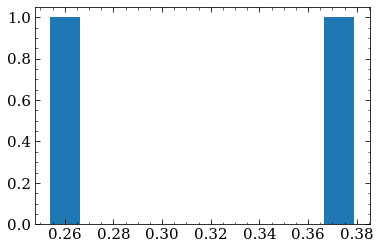

In [33]:
fig, ax = plt.subplots()
ax.hist(chi2s)
print(chi2s)

In [34]:
def plot_velo(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # if
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

    axmin = 350
    if plot_violin:
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos = (bin_pos[1:] + bin_pos[:-1])/2
        
        w = (bin_pos[1:] - bin_pos[:-1])
        ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=False)



    # else:  
    #     # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    #     ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
    #     if plot_lines:
    #         ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(axmin, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


N  0
[375.00500488 409.25457764 472.06390381 547.76434326 577.60766602]
[ 4.31087741  3.17288561 -7.26506804 -8.45622094 16.33117708]
[409.25457764 472.06390381 547.76434326 577.60766602]
(array([  0.04885478, -23.51240933]), array([[ 1.06052167e-02, -5.32894000e+00],
       [-5.32894000e+00,  2.72312239e+03]]))
(1, 6, 1)
[6.14218021]


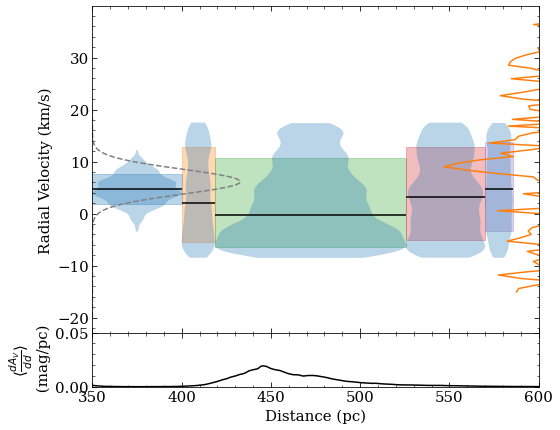

N  1
[375.00500488 419.78927612 455.03808594 475.51266479 485.52267456
 507.90985107]
[ 8.15904472  9.53152818  1.79460627 15.35270723 -6.49768237 -6.98881353]
[419.78927612 455.03808594 475.51266479 485.52267456 507.90985107]
(array([-0.17123816, 83.05435062]), array([[ 1.97995850e-02, -9.27320828e+00],
       [-9.27320828e+00,  4.36057367e+03]]))
(1, 6, 1)
[5.94630487]


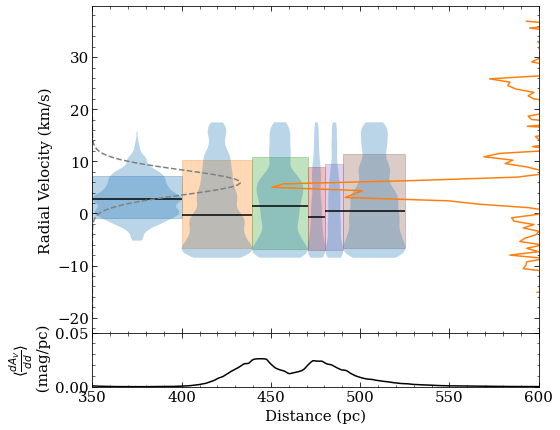

In [35]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

line = lambda x, m, b : m * x + b

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))


dist_xx_sl = np.array([])
velo_yy_sl = np.array([])
std_velo_sl = np.array([])

priorx = np.linspace(-20, 20, 100)

# for i in range(len(sightlines)): 
for i in range(0, len(sightlines)): 

    print('N ', i)
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})

    

    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color, 
                                                        plot_box = True, plot_violin=True, bestprob = True)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)



    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] > 400) & (dist_xx[dist_sort] <= 800)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        # axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    ### ADDDED 03.28 ###
    fgprior = prior_for_plot(sl_i.l, sl_i.b, priorx)
    axs[0].plot(5e2 * fgprior + 350, priorx, color = 'grey', linestyle = 'dashed')

    ### ADDED 03.31 ###
    profile, rvel = get_CO_profile(sl_i.l, sl_i.b)
    axs[0].plot(600- 5e1*profile, rvel)

    axs[1].plot(dust_data.distance, sl_davdd[i, :], color = 'k')
    # ax.set_ylim(ymin, ymax)
    axs[1].set_xlim(350, 600)
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
    axs[1].set_ylim(0, 0.05)
    fig.set_facecolor('white')

    # for j in range(len(sl_i.stars)):
    #     axs[1].scatter(sl_i.stars['DIST'][j], sl_davdd[i, find_nearest_dist(sl_i.stars['DIST'][j])])

    # axs[0].legend()
    # name_i = 'veldist_' + str(i)
    # fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )

    plt.show()

    dist_xx_sl = np.concatenate([dist_xx_sl, dist_xx])
    velo_yy_sl = np.concatenate([velo_yy_sl, velo_yy])
    std_velo_sl = np.concatenate([std_velo_sl, std_velo])

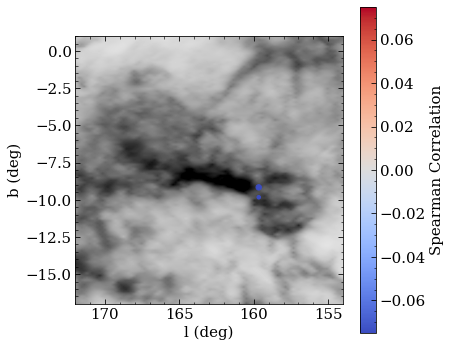

In [36]:
from scipy.stats import spearmanr
start = 0
stop = None
def gradientmetric_deriv(array, dist):    
    a, b = np.meshgrid(array, array)
    c, d = np.meshgrid(dist, dist)
    grad_matrix = np.triu(b - a)
    deltadist = np.triu(d - c)
    nz = grad_matrix != 0
    grad_matrix[nz] = grad_matrix[nz] / deltadist[nz]
    shape = grad_matrix.shape[0]
    return np.sum(grad_matrix) / (0.5 * shape * (shape - 1))

sl_metrics = np.zeros(len(sightlines))
sl_spearman = np.zeros((len(sightlines), 2))


v_all = np.array([], dtype = float)
verr_all = np.array([], dtype = float)
d_all = np.array([], dtype = float)
l_sightline = np.array([], dtype = float)
sl_counts = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    ndim = len(sl_i.voxel_dAVdd)
    walker_max = sl_i.sampler.chain.shape[1]
    min_walker_val = walker_max - 100
    sampler = sl_i.sampler
    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))
    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]
    bin_dist = sl_i.bins[1:]

    select_cloud = bin_dist > 400


    metric = np.sum(gradientmetric_deriv(med_velo[select_cloud], bin_dist[select_cloud]))
    sl_metrics[i] = metric

    spearman_correlation = spearmanr(bin_dist[select_cloud], med_velo[select_cloud])
    sl_spearman[i, 0] = spearman_correlation.correlation
    sl_spearman[i, 1] = spearman_correlation.pvalue

    v_all = np.concatenate([v_all,med_velo])
    verr_all = np.concatenate([verr_all, std_velo]) 
    d_all = np.concatenate([d_all, bin_dist])

    l_sightline = np.concatenate([l_sightline, l_sample[i] * np.ones(len(med_velo))])
    sl_counts[i] = len(med_velo)

fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(np.nansum(dust_data.dustmap, axis = 2), origin = 'lower', cmap = 'binary', vmin = 0, vmax = 3, extent = (dust_data.l0-9, dust_data.l0+9, dust_data.b0-9, dust_data.b0+9))
# masks = (np.nansum(edenhofer, axis = 2) >= 2.2).astype(float)
# masks_3 = (np.nansum(edenhofer, axis = 2) < 1.5).astype(float)
# im_mask = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Reds', alpha = masks, extent = (l0-9, l0+9, b0-9, b0+9))
# im_mask_3 = ax.imshow(np.nansum(edenhofer, axis = 2), origin = 'lower', cmap = 'Purples', alpha = masks_3, extent = (l0-9, l0+9, b0-9, b0+9))
points = ax.scatter(l_sample[:len(sightlines)], b_sample[:len(sightlines)], c = sl_spearman[:, 0], s= 100 * (1-sl_spearman[:, 1]), vmin = -0.075, vmax = 0.075, cmap = 'coolwarm')
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)
# fig.colorbar(im, label = "A(V)")
fig.colorbar(points, label = 'Spearman Correlation')
plt.show()

# sl_spearman.astype(np.float16)
# fig, ax = plt.subplots()
# fil = np.nansum(crit_filament)
# fil_idx = np.sum(sl_counts[:fil]).astype(int)

# ax.errorbar(d_all[:], v_all[:], yerr = verr_all[:], fmt = '.', capsize = 4, color = 'grey')

# points = ax.scatter(d_all[:], v_all[:], c = l_sightline[:], zorder = 5, )

# ax.set_xlim(380, 600)
# ax.set_xlabel('Distance (pc)')
# ax.set_ylabel('Velocity (km/s)')
# fig.colorbar(points, label = 'l (deg)')
# plt.show()

In [37]:
np.flip(np.argsort((sl_spearman[:, 0])))

array([0, 1])

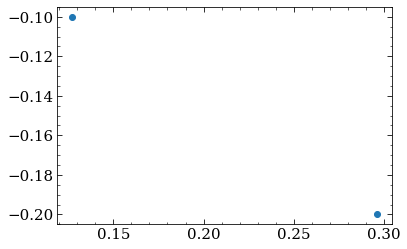

In [38]:
plt.scatter((1-sl_spearman[:, 1]), sl_spearman[:, 0])

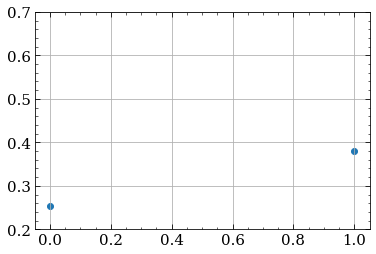

In [39]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(sightlines)), chi2s)
ax.set_ylim(0.2, 0.7)
ax.grid('on')

plt.show()

In [40]:
chi2_per_star = []
chi2_all = []
for i in range(len(sightlines)):
    sl = sightlines[i]
    recreated_signals_i = recreated_signals[i]


     #= np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    # chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / np.sum(np.isnan(sl.signals)==False, axis = 1)[:, np.newaxis], axis = 1)
    chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / (sl.signal_errs**2) , axis = 1)/ np.sum(np.isnan(sl.signals)==False, axis = 1)[:, np.newaxis]

    chi2_per_star.append(chi2_per_signal)

    chi2_all.append(np.sum(chi2_per_signal))

In [41]:
chi2_per_star = []
chi2_all = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl = sightlines[i]
    recreated_signals_i = recreated_signals[i]


     #= np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    # chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / np.sum(np.isnan(sl.signals)==False, axis = 1)[:, np.newaxis], axis = 1)
    chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / (sl.signal_errs**2) , axis = 1) / np.sum(np.isnan(sl.signals)==False, axis = 1)

    chi2_per_star.append(chi2_per_signal)
    chi2_all[i] = np.nansum((sl.signals - recreated_signals_i)**2 / (sl.signal_errs**2) ) / np.sum(np.isnan(sl.signals)==False,)


In [42]:
np.sum(np.isnan(sl.signals)==False, axis = 1)

array([86, 83, 83, 80, 80])

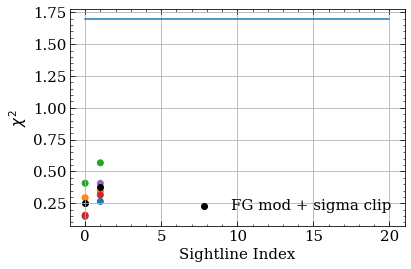

In [43]:
fig, ax = plt.subplots()
# ax.scatter(np.arange(len(sightlines)), chi2s, color = 'k')
for i in range(len(sightlines)):
    per_star_chi2s = chi2_per_star[i]
    c = ['C{}'.format(i) for i in range(len(per_star_chi2s))]
    ax.scatter(np.ones(len(per_star_chi2s)) * i, per_star_chi2s, c = c)
# ax.set_ylim(0.2, 0.7)
ax.scatter(np.arange(len(sightlines)), chi2_all, color = 'k', label = 'FG mod + sigma clip')
ax.grid('on')

ax.set_ylabel('$\chi^2$')
ax.set_xlabel('Sightline Index')
fig.set_facecolor('white')
ax.legend()
# plt.savefig('fg_sigmaclip.png')
ax.plot((0, 20), (1.7, 1.7))
plt.show()

In [44]:
np.argsort(chi2_all)

array([0, 1])

In [45]:
# 'hi''
